# Lab 7: Time-series Anomaly Detection



Pandas was updated on 03/04/2023 to version 2.0, which is not compatibile with tsfel. Dowgrade to 1.5.3

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel

## Import and settings

In [2]:
# !pip install keras_tuner

In [3]:
import os
import time
import tsfel
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold

from plots import *
from dataset import *
from metrics import *
from models_funtions import *

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [4]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal' #'/content/drive/MyDrive/dataset/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/dataset/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

#### Various parameters

In [5]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

file_name_normal = "_20220811_rbtc_"
file_name_collisions = "_collision_20220811_rbtc_"

recording_normal = [0, 2, 3, 4]
recording_collisions = [1, 5]

features_folder_normal = "../features/normal/"
features_folder_collisions = "../features/collisions/"

#### Data

In [6]:
df_features_normal, df_normal_raw, _, action2int_normal_raw = get_dataframes(ROOTDIR_DATASET_NORMAL, file_name_normal, recording_normal, freq, features_folder=f"{features_folder_normal}")
df_features_collisions, df_collisions_raw, df_collisions_raw_action, action2int_collisions_raw = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, recording_collisions, freq, features_folder=f"{features_folder_collisions}1_5/")
df_features_collisions_1, df_collisions_raw_1, df_collisions_raw_action_1, action2int_collisions_raw_action_1 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [1], freq, features_folder=f"{features_folder_collisions}1/")
df_features_collisions_5, df_collisions_raw_5, df_collisions_raw_action_5, action2int_collisions_raw_action_5 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [5], freq, features_folder=f"{features_folder_collisions}5/")

Loading data.
Found 31 different actions.
Loading data done.

Loading features from file.
--- 1.5680007934570312 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Loading features from file.
--- 0.02299976348876953 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Loading features from file.
--- 0.01799774169921875 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Loading features from file.
--- 0.019001245498657227 seconds ---


In [7]:
X_train, y_train, X_test, y_test, df_test = get_train_test_data(df_features_normal, df_features_collisions, full_normal=True)
X_train_1, y_train_1, X_test_1, y_test_1, df_test_1 = get_train_test_data(df_features_normal, df_features_collisions_1, full_normal=True)
X_train_5, y_train_5, X_test_5, y_test_5, df_test_5 = get_train_test_data(df_features_normal, df_features_collisions_5, full_normal=True)

d:\Dati\Users\Desktop\Poli\V\MLiA\Project\gabri_test\MLinAPP-FP01-14\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(
d:\Dati\Users\Desktop\Poli\V\MLiA\Project\gabri_test\MLinAPP-FP01-14\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(
d:\Dati\Users\Desktop\Poli\V\MLiA\Project\gabri_test\MLinAPP-FP01-14\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(


In [8]:
X_test.shape

(306, 96)

In [9]:
X_test_1.shape

(164, 96)

In [10]:
X_test_5.shape

(141, 96)

### Collisions

In [11]:
collisions_rec1, collisions_init1 = get_collisions('1', ROOTDIR_DATASET_ANOMALY)
collisions_rec5, collisions_init5 = get_collisions('5', ROOTDIR_DATASET_ANOMALY)

# Merge the collisions of the two recordings in one dataframe
collisions_rec = pd.concat([collisions_rec1, collisions_rec5])
collisions_init = pd.concat([collisions_init1, collisions_init5])

In [12]:
collisions_zones, y_collisions = get_collisions_zones_and_labels(collisions_rec, collisions_init, df_features_collisions)
collisions_zones_1, y_collisions_1 = get_collisions_zones_and_labels(collisions_rec1, collisions_init1, df_features_collisions_1)
collisions_zones_5, y_collisions_5 = get_collisions_zones_and_labels(collisions_rec5, collisions_init5, df_features_collisions_5)

### Random forest classifier

In [13]:
num_estims = [10, 100, 1000]
crits = ['gini', 'entropy', 'log_loss']
max_dept = [None, 50, 100, 1000]
min_s_splits = [2, 3]
max_features = ['sqrt', 'log2', None]

classifier = RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    max_depth = 1000,
    min_samples_split = 2,
    max_features = 'sqrt'
    )
# Train the RandomForestClassifier on normal data
classifier.fit(X_train, y_train)
print("Random Forest training completed.")

Random Forest training completed.


In [14]:
y_test_predict = classifier.predict_proba(X_test.values)

d:\Dati\Users\Desktop\Poli\V\MLiA\Project\gabri_test\MLinAPP-FP01-14\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [15]:
y_test_predict.argmax(axis=1)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, 20, 14,  2, 10,  6,  2,  2, 10, 10,  3,  3,  4,
        3,  3,  3,  3,  3,  3,  3, 11,  3,  3,  3,  3,  3,  3, 11, 11,  3,
       11, 11,  3, 11,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
       11, 11, 11, 11,  4,  4,  4,  4, 23, 21,  5,  5,  5,  1, 23,  5, 15,
       10,  6,  6,  6, 22,  8, 10,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  3,  8,  8,  8,  8,  8, 11,  8,  8,  8,  8,  3,  8,  8,  8,  3,
        3, 11,  8,  9,  9,  9,  9,  9,  9, 23,  9,  8, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12,  0, 12,
       12, 12, 12, 12, 12,  7, 12, 12, 12, 12, 12, 13, 13, 13, 13, 15, 13,
       14, 14, 14,  1, 14, 14, 15, 15, 15, 23,  1, 21, 16, 16, 16, 10, 16,
       16, 17, 17, 17, 17

Check the model performance

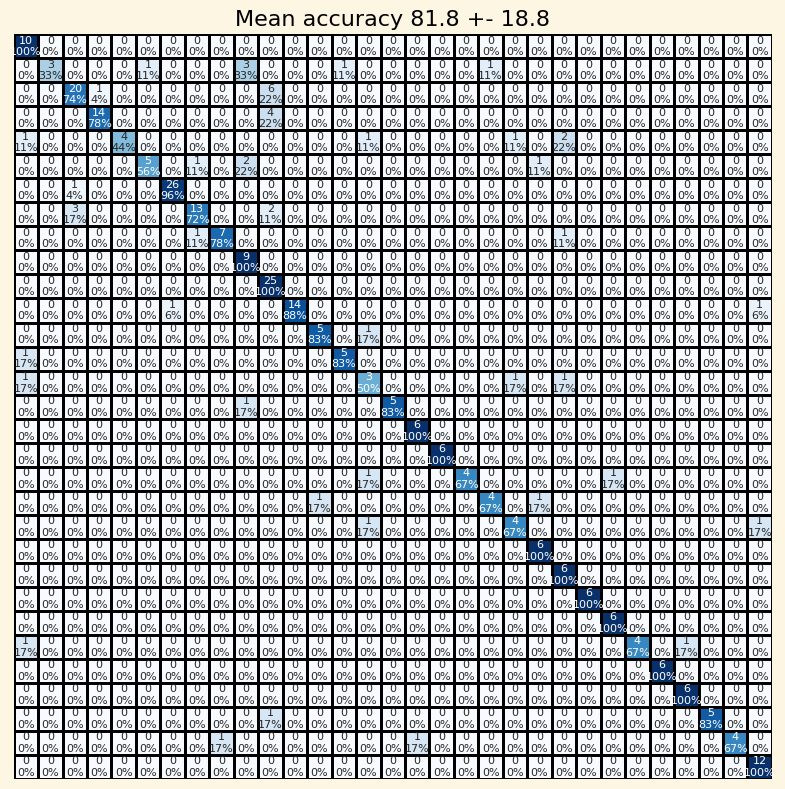

In [16]:
# Get confusion matrix
cm = confusion_matrix(y_test, y_test_predict.argmax(axis=1), labels=list(action2int_normal_raw.values()))
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
int2action = {v: k for k, v in action2int_normal_raw.items()}
seaborn_cm(cm,
            ax,
            [int2action[l] for l in action2int_normal_raw.values()], fontsize=8, xrotation=90)
plt.tight_layout()

# **TODO** Compute uncertainty

In [17]:
n_mc = 10
preds_array = np.array([classifier.predict_proba(X_test.values) for _ in range(n_mc)])
preds_bayes_mean = np.mean(np.array(preds_array), axis = 0)

d:\Dati\Users\Desktop\Poli\V\MLiA\Project\gabri_test\MLinAPP-FP01-14\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\Dati\Users\Desktop\Poli\V\MLiA\Project\gabri_test\MLinAPP-FP01-14\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\Dati\Users\Desktop\Poli\V\MLiA\Project\gabri_test\MLinAPP-FP01-14\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\Dati\Users\Desktop\Poli\V\MLiA\Project\gabri_test\MLinAPP-FP01-14\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\Dati\Users\Desktop\Poli\V\MLiA\Project\gabri_test

In [18]:
uncertainties_bayes = dict()
uncertainties_bayes["correct"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) == y_test), :]).compute_uncertainty_metrics()
uncertainties_bayes["wrong"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) != y_test), :]).compute_uncertainty_metrics()
uncertainties_bayes["all"] = Confidence(preds_array.mean(axis=0)).compute_uncertainty_metrics()

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


In [19]:
uncertainties_bayes["correct"]

{'entropy': array([0.01800723, 0.01800723, 0.2142392 , 0.22359243, 0.01800723,
        0.01800723, 0.03598197, 0.01800723, 0.01800723, 0.01800723,
        0.01800723, 0.80912299, 0.35880878, 0.87476052, 0.90958144,
        0.14210854, 0.81056656, 0.38712845, 0.43295771, 0.19504468,
        0.93406272, 0.53056267, 0.23506529, 0.91656312, 0.15147736,
        0.14799263, 0.79559962, 0.16562308, 0.07299095, 0.03152677,
        0.18321698, 0.11499715, 0.07299095, 0.15636912, 0.90245401,
        0.17343141, 0.14583898, 0.09948914, 0.88071947, 0.84419439,
        0.11143827, 0.11143827, 0.39883755, 0.50518673, 0.15159987,
        0.18629104, 0.15159987, 0.16401729, 0.08156865, 0.1652368 ,
        0.13594266, 0.11143827, 0.13559605, 0.0494687 , 0.04333071,
        0.14583898, 0.21590999, 0.11262373, 0.10857077, 0.86832993,
        0.20822521, 0.18815421, 0.23725413, 0.20969895, 0.12509073,
        0.14808912, 0.45201141, 0.2723558 , 0.83855329, 0.0494687 ,
        0.08079754, 0.03152677, 0.293

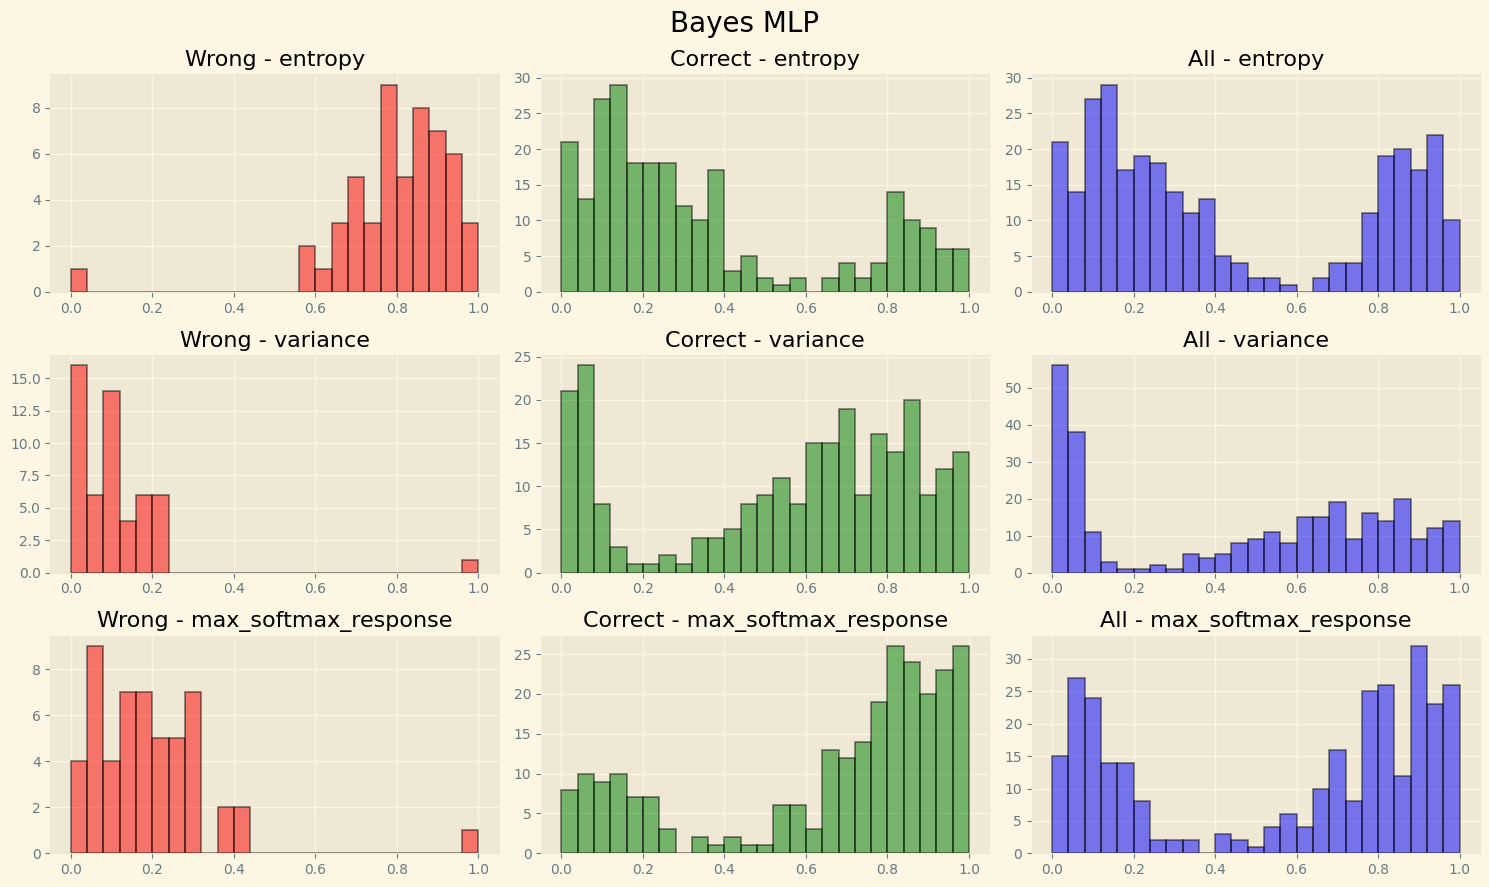

In [20]:
fig, axes = plt.subplots(len(uncertainties_bayes['correct'].keys()), 3, figsize=(15, 9))
for ax, measure in zip(axes, uncertainties_bayes['correct'].keys()):
    ax[0].set_title(f"Wrong - {measure}")
    ax[0].hist(uncertainties_bayes['wrong'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    ax[1].set_title(f"Correct - {measure}")
    ax[1].hist(uncertainties_bayes['correct'][measure], color="green", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    ax[2].set_title(f"All - {measure}")
    ax[2].hist(uncertainties_bayes['all'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
fig.suptitle("Bayes MLP", fontsize=20)
plt.tight_layout()

# Load collisions and extract features

In [21]:
collisions = pd.read_excel(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

In [22]:
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.metadata") for r in [1, 5]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.



In [23]:
filepath_csv_1 = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.csv") for r in [1]]
filepath_meta_1 = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.metadata") for r in [1]]
df_action_1, df_1, df_meta_1, action2int_1 = get_df_action(filepath_csv_1, filepath_meta_1)

Loading data.
Found 31 different actions.
Loading data done.



In [24]:
filepath_csv_5 = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.csv") for r in [5]]
filepath_meta_5 = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.metadata") for r in [5]]
df_action_5, df_5, df_meta_5, action2int_5 = get_df_action(filepath_csv_5, filepath_meta_5)

Loading data.
Found 31 different actions.
Loading data done.



In [25]:
start_time = time.time()
df_features_collision = get_features_ts("statistical", df_action, df_meta, 10, action2int, None)
df_features_collision_1 = get_features_ts("statistical", df_action_1, df_meta_1, 10, action2int_1, None)
df_features_collision_5 = get_features_ts("statistical", df_action_5, df_meta_5, 10, action2int_5, None)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features.


Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
--- 87.22481536865234 seconds ---


In [26]:
start_time = time.time()
df_features_collision = get_features_ts("statistical", df_action, df_meta, 10, action2int, None)
df_features_collision_1 = get_features_ts("statistical", df_action_1, df_meta_1, 10, action2int_1, None)
df_features_collision_5 = get_features_ts("statistical", df_action_5, df_meta_5, 10, action2int_5, None)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features.


Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
--- 85.3395049571991 seconds ---


In [27]:
df_features_collision_1.shape

(164, 2203)

Preprocessing

In [28]:
# df_features_collision.isnull().values.any()

In [29]:
df_features_collision_nonan = df_features_collision.fillna(0)
df_features_collision_nonan_1 = df_features_collision_1.fillna(0)
df_features_collision_nonan_5 = df_features_collision_5.fillna(0)

In [30]:
df_features_collision_nonan_1.shape

(164, 2203)

In [31]:
# X_collision = df_features_collision_nonan.drop(["label", "start", "end"], axis=1)
# y_collision = df_features_collision_nonan["label"]
# X_collision.shape

In [32]:
# X_collision_1 = df_features_collision_nonan_1.drop(["label", "start", "end"], axis=1)
# y_collision_1 = df_features_collision_nonan_1["label"]

In [33]:
# X_collision_5 = df_features_collision_nonan_5.drop(["label", "start", "end"], axis=1)
# y_collision_5 = df_features_collision_nonan_5["label"]
# X_collision_5.shape

# **TODO** Compute uncertainty

In [34]:
preds_array_collisions = np.array([classifier.predict_proba(X_test.values) for _ in range(n_mc)])
preds_bayes_mean_collision = np.mean(np.array(preds_array_collisions), axis = 0)

In [35]:
preds_array_collisions_1 = np.array([classifier.predict_proba(X_test_1.values) for _ in range(n_mc)])
preds_bayes_mean_collision_1 = np.mean(np.array(preds_array_collisions_1), axis = 0)

In [36]:
preds_array_collisions_5 = np.array([classifier.predict_proba(X_test_5.values) for _ in range(n_mc)])
preds_bayes_mean_collision_5 = np.mean(np.array(preds_array_collisions_5), axis = 0)

In [37]:
uncertainties_bayes = dict()
uncertainties_bayes["correct"] = Confidence(preds_array_collisions.mean(axis=0)[(preds_bayes_mean_collision.argmax(axis=1) == y_collisions), :]).compute_uncertainty_metrics()
uncertainties_bayes["wrong"] = Confidence(preds_array_collisions.mean(axis=0)[(preds_bayes_mean_collision.argmax(axis=1) != y_collisions), :]).compute_uncertainty_metrics()
uncertainties_bayes["all"] = Confidence(preds_array_collisions.mean(axis=0)).compute_uncertainty_metrics()

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


In [38]:
uncertainties_bayes_1 = dict()
uncertainties_bayes_1["correct"] = Confidence(preds_array_collisions_1.mean(axis=0)[(preds_bayes_mean_collision_1.argmax(axis=1) == y_collisions_1), :]).compute_uncertainty_metrics()
uncertainties_bayes_1["wrong"] = Confidence(preds_array_collisions_1.mean(axis=0)[(preds_bayes_mean_collision_1.argmax(axis=1) != y_collisions_1), :]).compute_uncertainty_metrics()
uncertainties_bayes_1["all"] = Confidence(preds_array_collisions_1.mean(axis=0)).compute_uncertainty_metrics()

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


In [39]:
uncertainties_bayes_5 = dict()
uncertainties_bayes_5["correct"] = Confidence(preds_array_collisions_5.mean(axis=0)[(preds_bayes_mean_collision_5.argmax(axis=1) == y_collisions_5), :]).compute_uncertainty_metrics()
uncertainties_bayes_5["wrong"] = Confidence(preds_array_collisions_5.mean(axis=0)[(preds_bayes_mean_collision_5.argmax(axis=1) != y_collisions_5), :]).compute_uncertainty_metrics()
uncertainties_bayes_5["all"] = Confidence(preds_array_collisions_5.mean(axis=0)).compute_uncertainty_metrics()

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


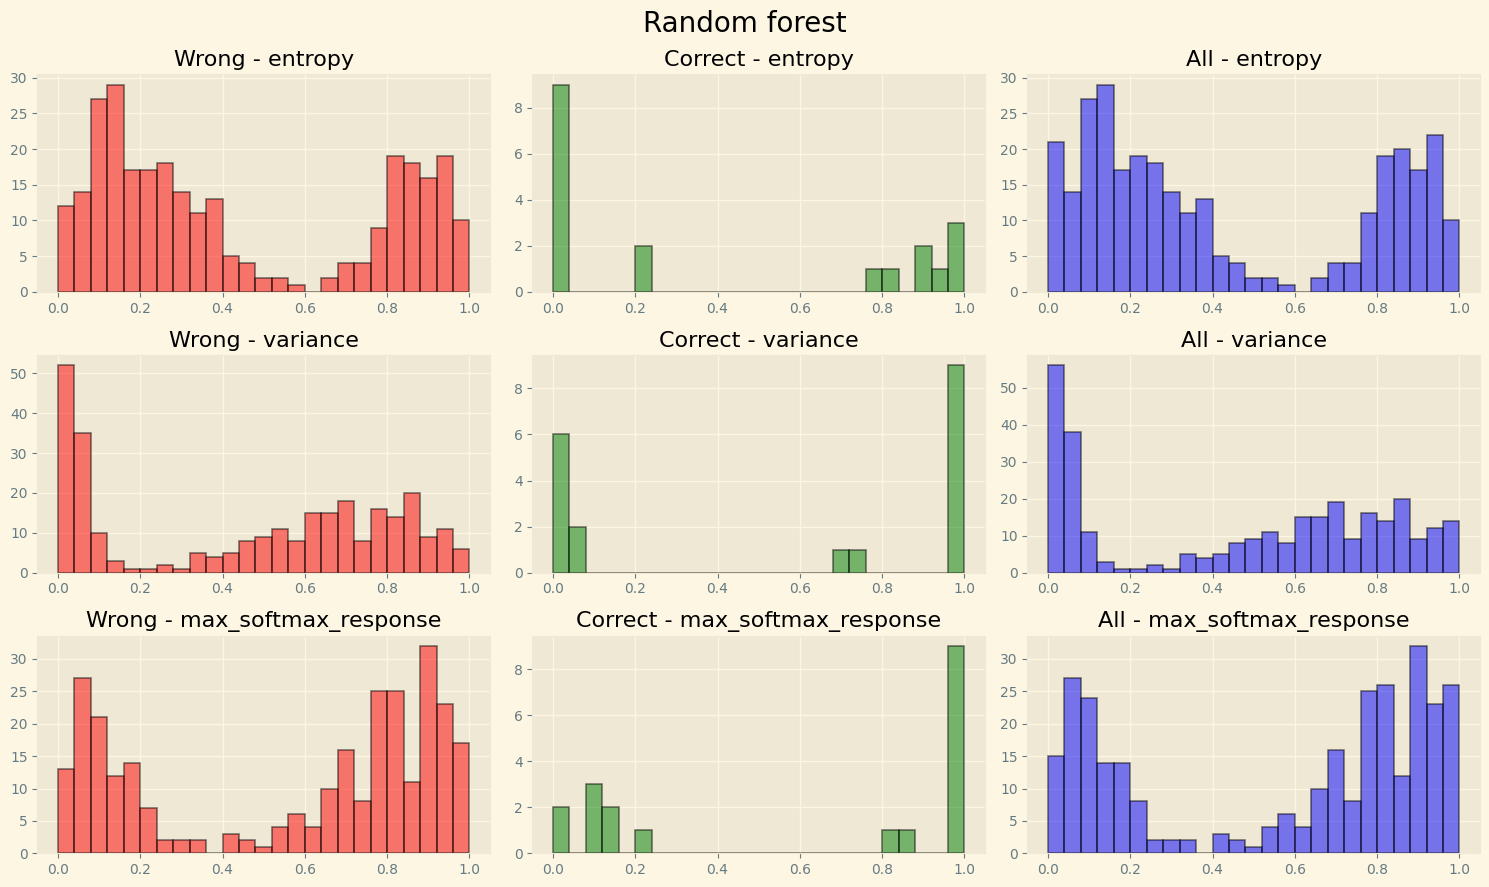

In [40]:
fig, axes = plt.subplots(len(uncertainties_bayes['correct'].keys()), 3, figsize=(15, 9))
for ax, measure in zip(axes, uncertainties_bayes['correct'].keys()):
    ax[0] .set_title(f"Wrong - {measure}")
    ax[0].hist(uncertainties_bayes['wrong'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    ax[1] .set_title(f"Correct - {measure}")
    ax[1].hist(uncertainties_bayes['correct'][measure], color="green", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    ax[2] .set_title(f"All - {measure}")
    ax[2].hist(uncertainties_bayes['all'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
fig.suptitle("Random forest", fontsize=20)
plt.tight_layout()

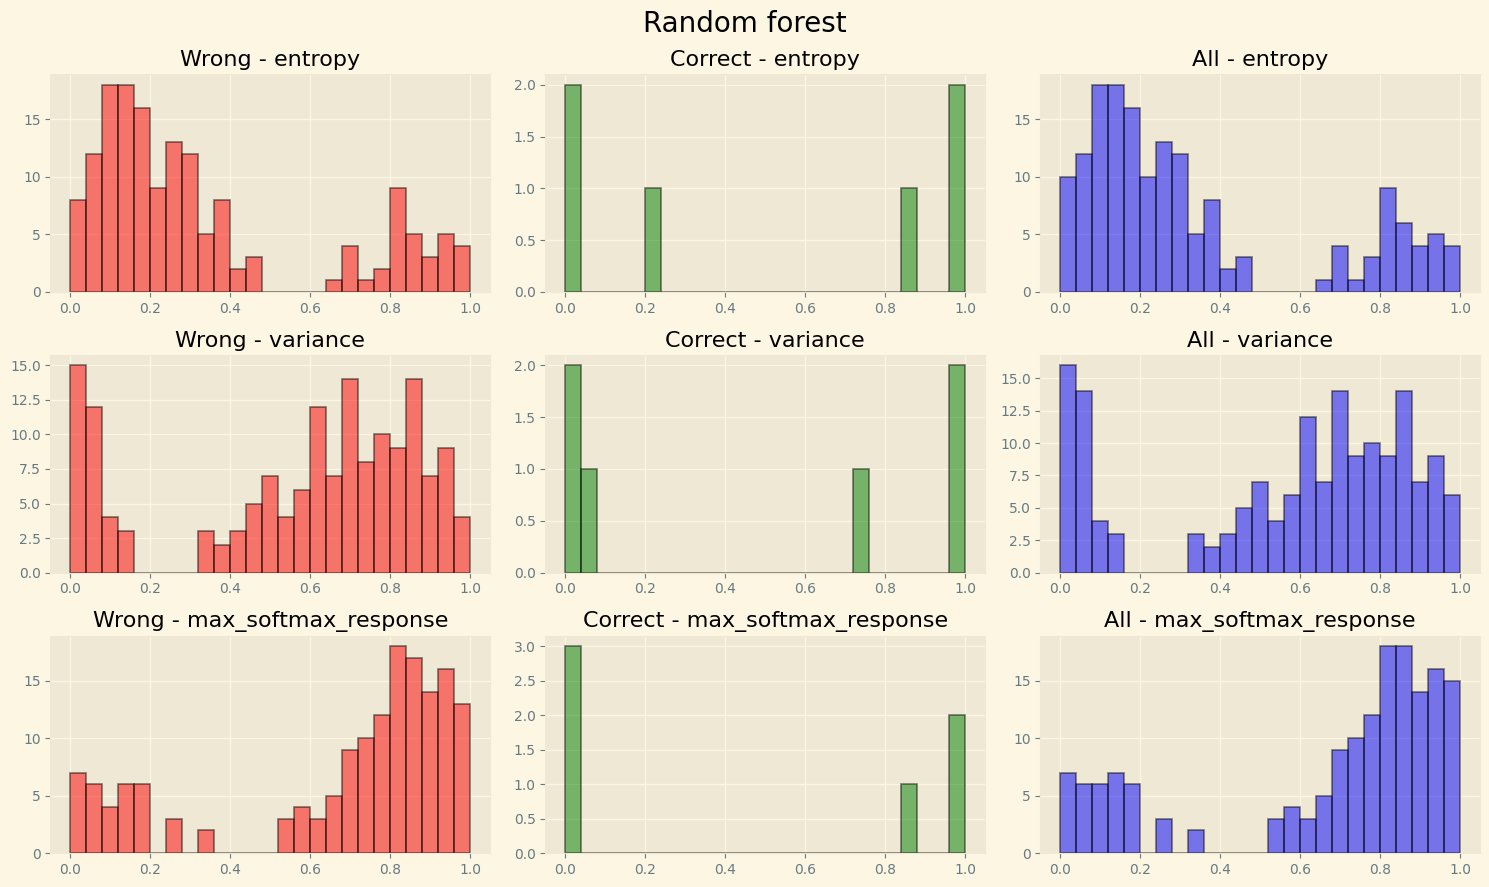

In [41]:
fig, axes = plt.subplots(len(uncertainties_bayes_1['correct'].keys()), 3, figsize=(15, 9))
for ax, measure in zip(axes, uncertainties_bayes_1['correct'].keys()):
    ax[0] .set_title(f"Wrong - {measure}")
    ax[0].hist(uncertainties_bayes_1['wrong'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    ax[1] .set_title(f"Correct - {measure}")
    ax[1].hist(uncertainties_bayes_1['correct'][measure], color="green", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    ax[2] .set_title(f"All - {measure}")
    ax[2].hist(uncertainties_bayes_1['all'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
fig.suptitle("Random forest", fontsize=20)
plt.tight_layout()

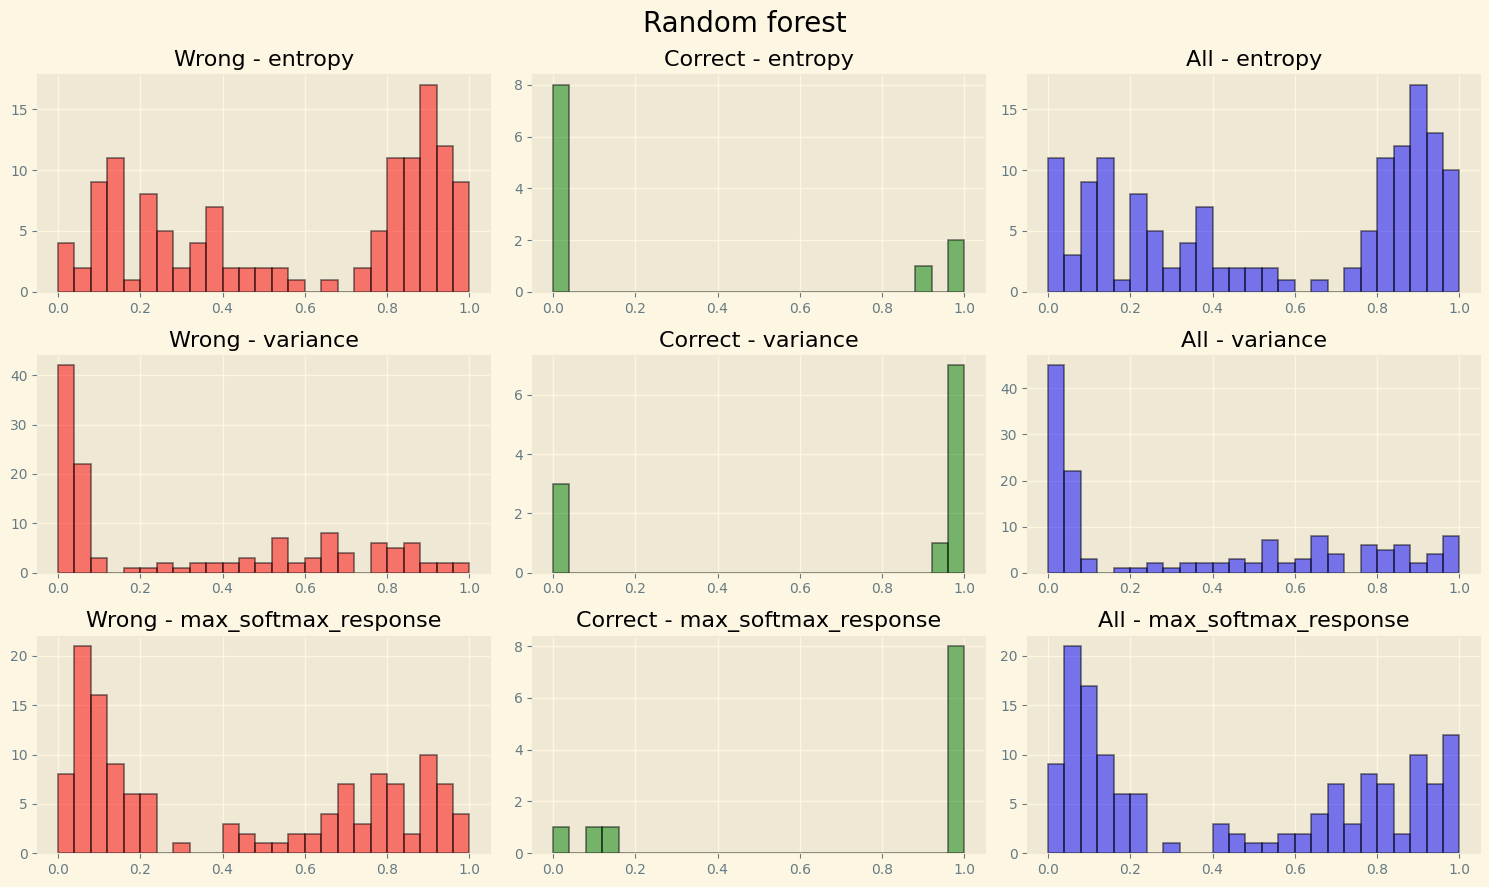

In [42]:
fig, axes = plt.subplots(len(uncertainties_bayes_5['correct'].keys()), 3, figsize=(15, 9))
for ax, measure in zip(axes, uncertainties_bayes_5['correct'].keys()):
    ax[0] .set_title(f"Wrong - {measure}")
    ax[0].hist(uncertainties_bayes_5['wrong'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    ax[1] .set_title(f"Correct - {measure}")
    ax[1].hist(uncertainties_bayes_5['correct'][measure], color="green", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    ax[2] .set_title(f"All - {measure}")
    ax[2].hist(uncertainties_bayes_5['all'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
fig.suptitle("Random forest", fontsize=20)
plt.tight_layout()

# Assess TAD algorithm performance via ROC curves

In [43]:
roc_dict = dict()
for confidence_metric in uncertainties_bayes['correct'].keys():
    confidence = uncertainties_bayes['all'][confidence_metric]
    if confidence_metric == "entropy":
        confidence = 1- confidence
    sens = list()
    fpr = list()
    for threshold in np.arange(0, 1, 0.1):
        df_not_confident = df_features_collision_nonan[confidence <= threshold]
        anomaly_indexes = list()
        tp = 0
        for anomaly in collisions_init:
            for index, row in df_not_confident.iterrows():
                if anomaly >= row['start'] and anomaly <= row['end']:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2, 2))
        n_samples = len(df_features_collision_nonan)
        n_not_collisions = n_samples - len(collisions_init)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(collisions_init) - tp
        tn = n_not_collisions - fp
        cm_anomaly[0][0] = tn
        cm_anomaly[1][1] = tp
        cm_anomaly[0][1] = fp
        cm_anomaly[1][0] = fn
        sens.append(tp / (tp + fn))
        fpr.append(1 - tn / (fp + tn))
    roc_dict[confidence_metric] = (fpr, sens)

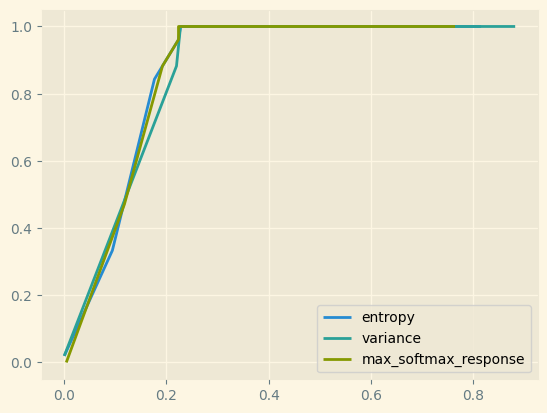

In [44]:
fig, ax = plt.subplots(1, 1)
for confidence_metric in uncertainties_bayes['correct'].keys():
    ax.plot(roc_dict[confidence_metric][0], roc_dict[confidence_metric][1], label=confidence_metric)
ax.legend();

In [45]:
roc_dict = dict()
for confidence_metric in uncertainties_bayes_1['correct'].keys():
    confidence = uncertainties_bayes_1['all'][confidence_metric]
    if confidence_metric == "entropy":
        confidence = 1- confidence
    sens = list()
    fpr = list()
    for threshold in np.arange(0, 1, 0.1):
        df_not_confident = df_features_collision_nonan_1[confidence <= threshold]
        anomaly_indexes = list()
        tp = 0
        for anomaly in collisions_init:
            for index, row in df_not_confident.iterrows():
                if anomaly >= row['start'] and anomaly <= row['end']:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2, 2))
        n_samples = len(df_features_collision_nonan_1)
        n_not_collisions = n_samples - len(collisions_init)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(collisions_init) - tp
        tn = n_not_collisions - fp
        cm_anomaly[0][0] = tn
        cm_anomaly[1][1] = tp
        cm_anomaly[0][1] = fp
        cm_anomaly[1][0] = fn
        sens.append(tp / (tp + fn))
        fpr.append(1 - tn / (fp + tn))
    roc_dict[confidence_metric] = (fpr, sens)

In [46]:
confidence.shape

(164,)

In [47]:
df_features_collision_nonan_1.shape

(164, 2203)

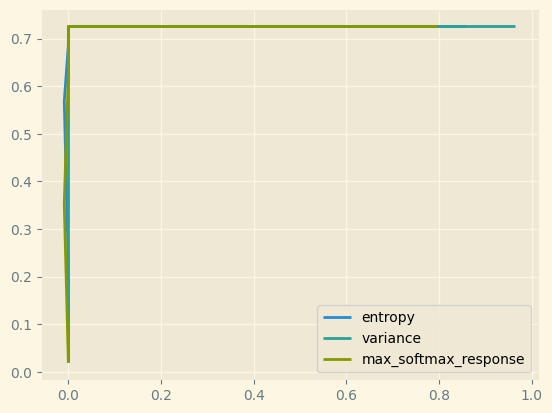

In [48]:
fig, ax = plt.subplots(1, 1)
for confidence_metric in uncertainties_bayes_1['correct'].keys():
    ax.plot(roc_dict[confidence_metric][0], roc_dict[confidence_metric][1], label=confidence_metric)
ax.legend();

In [49]:
roc_dict = dict()
for confidence_metric in uncertainties_bayes_5['correct'].keys():
    confidence = uncertainties_bayes_5['all'][confidence_metric]
    if confidence_metric == "entropy":
        confidence = 1- confidence
    sens = list()
    fpr = list()
    for threshold in np.arange(0, 1, 0.1):
        df_not_confident = df_features_collision_nonan_5[confidence <= threshold]
        anomaly_indexes = list()
        tp = 0
        for anomaly in collisions_init:
            for index, row in df_not_confident.iterrows():
                if anomaly >= row['start'] and anomaly <= row['end']:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2, 2))
        n_samples = len(df_features_collision_nonan_5)
        n_not_collisions = n_samples - len(collisions_init)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(collisions_init) - tp
        tn = n_not_collisions - fp
        cm_anomaly[0][0] = tn
        cm_anomaly[1][1] = tp
        cm_anomaly[0][1] = fp
        cm_anomaly[1][0] = fn
        sens.append(tp / (tp + fn))
        fpr.append(1 - tn / (fp + tn))
    roc_dict[confidence_metric] = (fpr, sens)

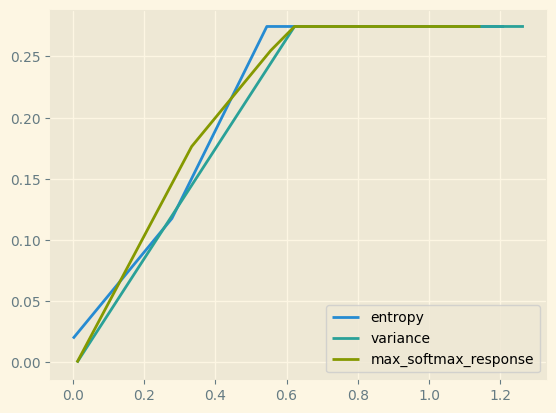

In [50]:
fig, ax = plt.subplots(1, 1)
for confidence_metric in uncertainties_bayes_5['correct'].keys():
    ax.plot(roc_dict[confidence_metric][0], roc_dict[confidence_metric][1], label=confidence_metric)
ax.legend();